In [78]:
#----IMPORT LIBRAIRIES----
import pandas as pd
import numpy as np
import seaborn as sns
import json
import math
from scipy.stats import zscore

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.io as pio
from plotly.subplots import make_subplots

import pvlib

import mlflow
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

import mlflow

import boto3

from dotenv import load_dotenv
import os

load_dotenv()
os.environ["MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING"] = "false"

import Model_func as mf
import func_cleaning as fc
import func_feat_eng as ffe

In [ ]:
#---VARIABLES----
weather_data_path = 'https://renergies99-lead-bucket.s3.eu-west-3.amazonaws.com/public/openweathermap/merge_openweathermap_cleaned.csv'
solar_data_path = 'https://renergies99-lead-bucket.s3.eu-west-3.amazonaws.com/public/solar/raw_solar_data.csv'
landsat_data_path = 'https://renergies99-lead-bucket.s3.eu-west-3.amazonaws.com/public/LandSat/result_EarthExplorer_region_ARA.csv'

col_solar = ['Time', 'Ap', '10cm', 'K index Planetary'] # ALWAYS include a 'Time' column (used to merge datasets)
prod_data_path = 'https://renergies99-lead-bucket.s3.eu-west-3.amazonaws.com/public/prod/eCO2mix_RTE_Auvergne-Rhone-Alpes_cleaned.csv'
target = 'tch_solaire_(%)'

cities_list = ['Moulins', 'Annecy', 'Nyons', 'Saint-Étienne', 'Aurillac']
#cities_list = ['Moulins']

# DATA COLLECTION & CLEANING

In [80]:
#--- Data Collection ----
full_dataset = fc.create_full_dataset(weather_data_path, solar_data_path, landsat_data_path, prod_data_path, 
                                   cities_list, col_solar, target)

df = full_dataset.copy()
df_no_Nan = fc.handle_nan(df)
df_clean = fc.clean_dataframe(df_no_Nan, type='numeric')
df_no_outliers= fc.remove_outliers(df_clean, target, method='iqr')
df_final = df_no_outliers.copy()

In [91]:
# Modif liée à la signature dans MLFlow qui retournait une erreur
cols = df_final.select_dtypes(include="int64").columns.to_list()
df_final[cols] = df_final[cols].astype(float)

X = df_final.drop(target, axis=1)
y = df_final[target]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

# VISUALISATIONS

target distributions

In [82]:
px.histogram(df_final, x=target, 
             title='Distribution de la cible', 
             width=800, height=600)

## colonnes 'humidity'

In [83]:
variables = [city + '_humidity' for city in cities_list]
df_humidity = df_final[variables + [target]]
df_humidity.head()

,Moulins_humidity,Annecy_humidity,Nyons_humidity,Saint-Étienne_humidity,Aurillac_humidity,tch_solaire_(%)
0,83.0,74.0,62.0,75.0,61.0,13.28
1,73.0,68.0,80.0,69.0,62.0,15.04
2,79.0,68.0,71.0,69.0,74.0,16.81
3,92.0,74.0,64.0,70.0,92.0,9.24
4,97.0,100.0,76.0,87.0,98.0,7.82


In [84]:
n_cols = 1
n_rows = len(variables)  # une ligne par variable
figure = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=variables
)

row = 1
col = 1

for variable in variables:
    # Crée un scatter avec trendline pour la variable courante
    f = px.scatter(df_humidity, x=variable, y=target, trendline='ols')
    
    # Ajoute toutes les traces (points + trendline) au subplot
    for trace in f.data:
        figure.add_trace(trace, row=row, col=col)
    
    # Passe à la ligne suivante si plusieurs colonnes
    row += 1

figure.update_layout(height=300 * n_rows, width=800, showlegend=False)
figure.show()


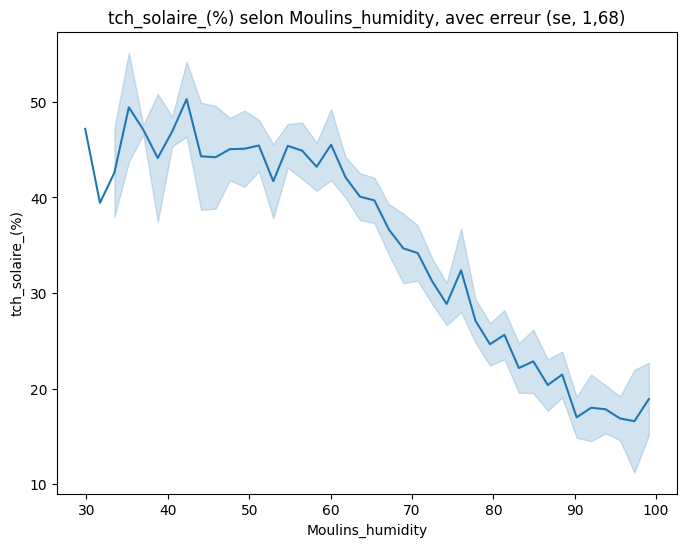

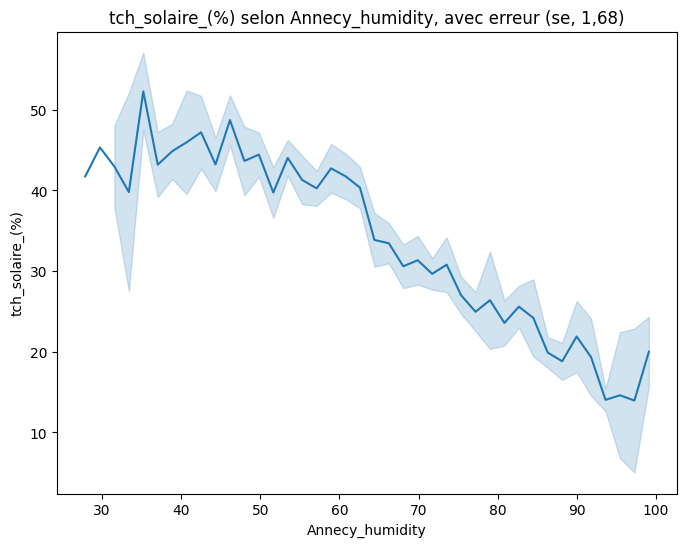

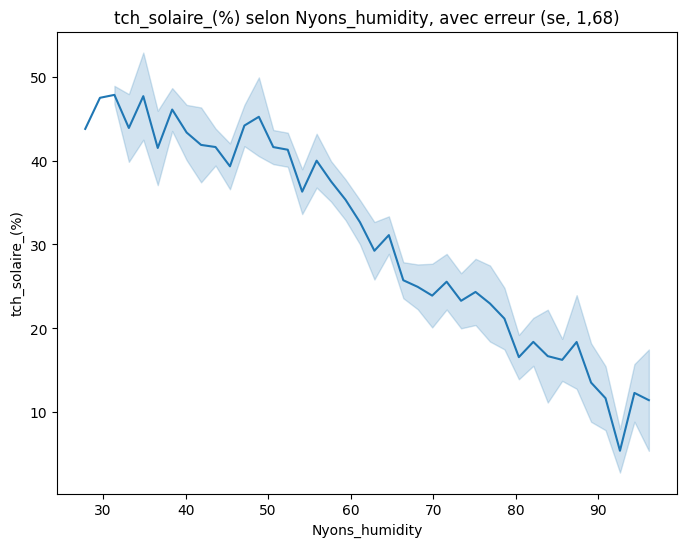

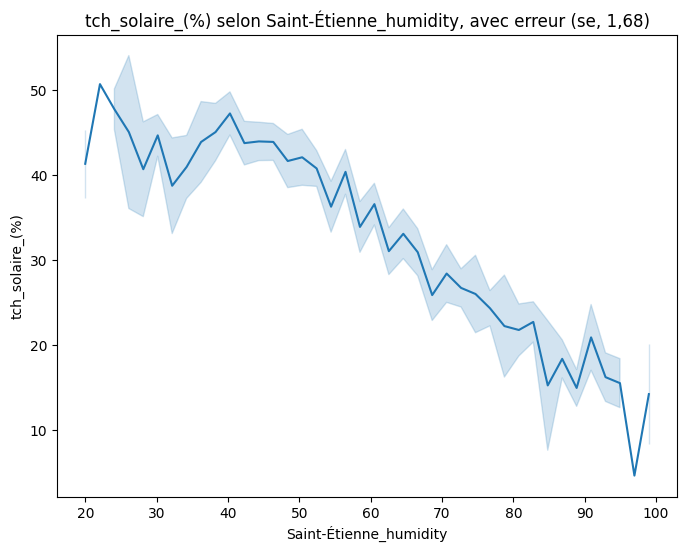

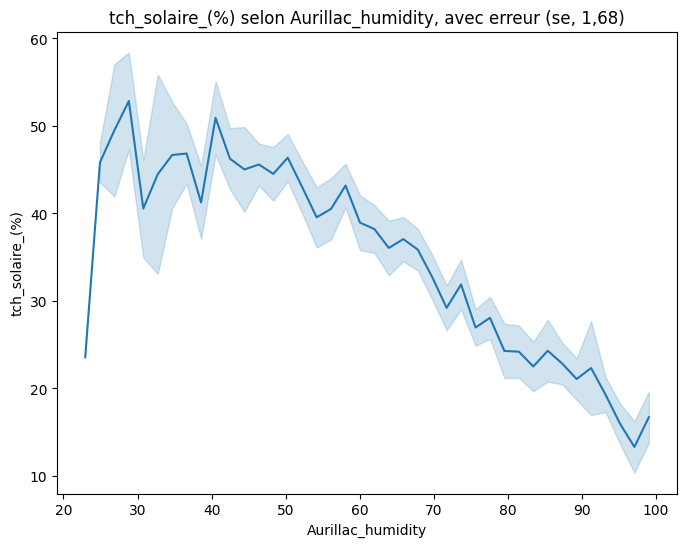

In [85]:
bins = {'Moulins_humidity':40, 'Annecy_humidity':40, 'Nyons_humidity':40,
        'Saint-Étienne_humidity':40, 'Aurillac_humidity':40}

quantized_df_humidity = pd.DataFrame()
quantized_df_humidity[target] = df_humidity[target]

for col in variables:
    # Calcul des intervalles avec pd.cut
    cut_result = pd.cut(df_humidity[col], bins=bins[col], retbins=True)
    bins_edges = cut_result[1]  # récupère les bornes des bins

    # Créer les labels = médiane de chaque intervalle
    labels = [(bins_edges[i] + bins_edges[i+1])/2 for i in range(len(bins_edges)-1)]

    # Appliquer pd.cut avec labels
    quantized_df_humidity[col] = pd.cut(df_humidity[col], bins=bins[col], labels=labels)
    
    plt.figure(figsize=(8,6))
    sns.lineplot(quantized_df_humidity, x=col, y=target, errorbar=('se',1.68))
    plt.title(f'{target} selon {col}, avec erreur (se, 1,68)')
    plt.show()


Récupération des données ML Flow pour appliquer le preprocessing

In [ ]:
# Variables requises pour retrouver le modele dans ML Flow
url = "https://renergies99lead-mlflow.hf.space/"
mlflow.set_tracking_uri(url)

run_id = '53d86f83214345a2a392c781c949064b' #super_popular_panda
model_path = "model"  # chemin dans l'artifact store

model_uri = f"runs:/{run_id}/{model_path}"
loaded_model = mlflow.pyfunc.load_model(model_uri)
run_info = mlflow.get_run(run_id)
run_name = run_info.data.tags.get("mlflow.runName")

print(f"Modèle {run_name} chargé !")

loaded_model


Modèle super_popular_panda chargé !


mlflow.pyfunc.loaded_model:
  artifact_path: s3://renergies99-mlflow/5/models/m-92bf2add73c24ed0890cbfa8aaf07ac0/artifacts
  flavor: mlflow.sklearn
  run_id: 53d86f83214345a2a392c781c949064b

In [89]:
y_pred = loaded_model.predict(X)
y_true = df_final[target]

In [88]:
sk_model = loaded_model._model_impl.sklearn_model
preprocessor = sk_model.named_steps['preprocessor']
preprocessor


,transformers,"[('split_cols', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,func,<function spl...002DB5D96D800>
,inverse_func,None
,validate,False


In [101]:
# Création du DataFrame pour Plotly Express
df_plot = pd.DataFrame({
    'y_test': y_test,
    'y_pred': loaded_model.predict(x_test)
})

# Scatter plot
fig = px.scatter(
    df_plot,
    x='y_test',
    y='y_pred',
    labels={'y_test': 'Valeurs réelles tch', 'y_pred': 'Prédictions'},
    title='Prédictions vs Valeurs réelles'
)

# Ajouter une ligne y=x pour visualiser l’idéal
fig.add_shape(
    type='line',
    x0=df_plot['y_test'].min(),
    y0=df_plot['y_test'].min(),
    x1=df_plot['y_test'].max(),
    y1=df_plot['y_test'].max(),
    line=dict(color='red', dash='dash')
)
fig.update_layout(width=1000, height=600)
fig.update_layout(
    width=1000, height=600,
    margin=dict(t=50)
)

fig.show()
